Confirmed by Omar

Project idea: predicting the severity level of a car crash. Classification.


Data: US Accidents (2016 - 2023)


In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload() # Upload the kaggle.json file you just downloaded

# Make directory and move the file
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json # Set permissions

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d sobhanmoosavi/us-accidents

Dataset URL: https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents
License(s): CC-BY-NC-SA-4.0


In [4]:
!unzip us-accidents.zip

Archive:  us-accidents.zip
  inflating: US_Accidents_March23.csv  


In [5]:
!nvidia-smi

Wed Apr 16 23:11:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             46W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [6]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import accuracy_score, confusion_matrix

# Import GPU-based (cuML) libraries
import cudf
import cuml
from cuml.linear_model import LogisticRegression
from cuml.model_selection import train_test_split
from cuml.preprocessing import StandardScaler
from cuml.model_selection import GridSearchCV

In [7]:
start_load_time = time.time()
accidents_gdf = cudf.read_csv('/content/US_Accidents_March23.csv')
load_time = time.time() - start_load_time
print(f"Data loaded in {load_time:.2f} seconds")

Data loaded in 1.20 seconds


In [8]:
print("\nDataset shape:", accidents_gdf.shape)
print("\nSample of the data:")
print(accidents_gdf.head())
print("\nClass distribution:")
print(accidents_gdf['Severity'].value_counts())


Dataset shape: (7728394, 46)

Sample of the data:
    ID   Source  Severity           Start_Time             End_Time  \
0  A-1  Source2         3  2016-02-08 05:46:00  2016-02-08 11:00:00   
1  A-2  Source2         2  2016-02-08 06:07:59  2016-02-08 06:37:59   
2  A-3  Source2         2  2016-02-08 06:49:27  2016-02-08 07:19:27   
3  A-4  Source2         3  2016-02-08 07:23:34  2016-02-08 07:53:34   
4  A-5  Source2         2  2016-02-08 07:39:07  2016-02-08 08:09:07   

   Start_Lat  Start_Lng End_Lat End_Lng  Distance(mi)  ... Roundabout  \
0  39.865147 -84.058723    <NA>    <NA>          0.01  ...      False   
1  39.928059 -82.831184    <NA>    <NA>          0.01  ...      False   
2  39.063148 -84.032608    <NA>    <NA>          0.01  ...      False   
3  39.747753 -84.205582    <NA>    <NA>          0.01  ...      False   
4  39.627781 -84.188354    <NA>    <NA>          0.01  ...      False   

   Station   Stop  Traffic_Calming  Traffic_Signal  Turning_Loop  \
0    False  Fal

In [9]:
missing_percentages = accidents_gdf.isnull().mean() * 100
print("Percentage of missing values in each column:")
print(missing_percentages)

Percentage of missing values in each column:
ID                        0.000000
Source                    0.000000
Severity                  0.000000
Start_Time                0.000000
End_Time                  0.000000
Start_Lat                 0.000000
Start_Lng                 0.000000
End_Lat                  44.029355
End_Lng                  44.029355
Distance(mi)              0.000000
Description               0.000065
Street                    0.140637
City                      0.003274
County                    0.000000
State                     0.000000
Zipcode                   0.024779
Country                   0.000000
Timezone                  0.101030
Airport_Code              0.292881
Weather_Timestamp         1.555666
Temperature(F)            2.120143
Wind_Chill(F)            25.865904
Humidity(%)               2.253301
Pressure(in)              1.820288
Visibility(mi)            2.291524
Wind_Direction            2.267043
Wind_Speed(mph)           7.391355
Precipitat

In [10]:
print(f"Original shape: {accidents_gdf.shape}")

columns_to_remove = [
    'ID',
    'End_Time',
    'End_Lat',
    'End_Lng',
    'Description',
    'Country',
    'Weather_Timestamp',
    'Street',
    'Airport_Code',
    'Timezone',
    'Turning_Loop'
]

accidents_gdf = accidents_gdf.drop(columns=columns_to_remove)

print(f"New shape after dropping: {accidents_gdf.shape}")
print(f"Remaining columns: {accidents_gdf.columns.to_list()}")

Original shape: (7728394, 46)
New shape after dropping: (7728394, 35)
Remaining columns: ['Source', 'Severity', 'Start_Time', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'City', 'County', 'State', 'Zipcode', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']


In [11]:
missing_percentages = accidents_gdf.isnull().mean() * 100
print("Percentage of missing values in each column:")
print(missing_percentages)

Percentage of missing values in each column:
Source                    0.000000
Severity                  0.000000
Start_Time                0.000000
Start_Lat                 0.000000
Start_Lng                 0.000000
Distance(mi)              0.000000
City                      0.003274
County                    0.000000
State                     0.000000
Zipcode                   0.024779
Temperature(F)            2.120143
Wind_Chill(F)            25.865904
Humidity(%)               2.253301
Pressure(in)              1.820288
Visibility(mi)            2.291524
Wind_Direction            2.267043
Wind_Speed(mph)           7.391355
Precipitation(in)        28.512858
Weather_Condition         2.244438
Amenity                   0.000000
Bump                      0.000000
Crossing                  0.000000
Give_Way                  0.000000
Junction                  0.000000
No_Exit                   0.000000
Railway                   0.000000
Roundabout                0.000000
Station   

In [12]:
accidents_gdf_A = accidents_gdf.copy()

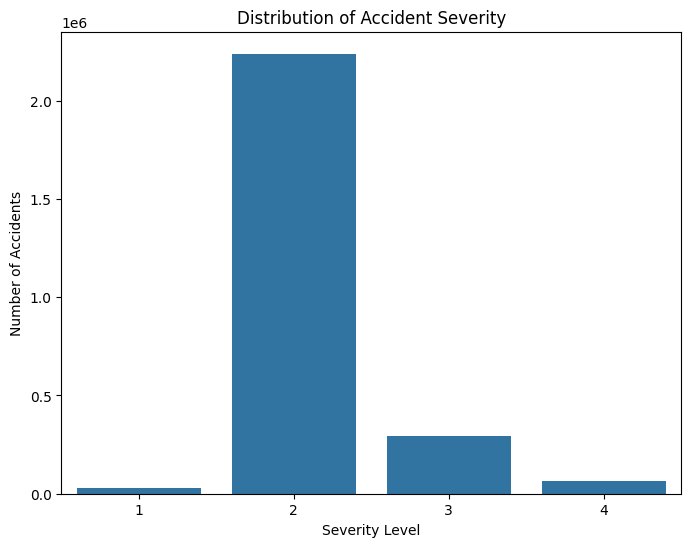

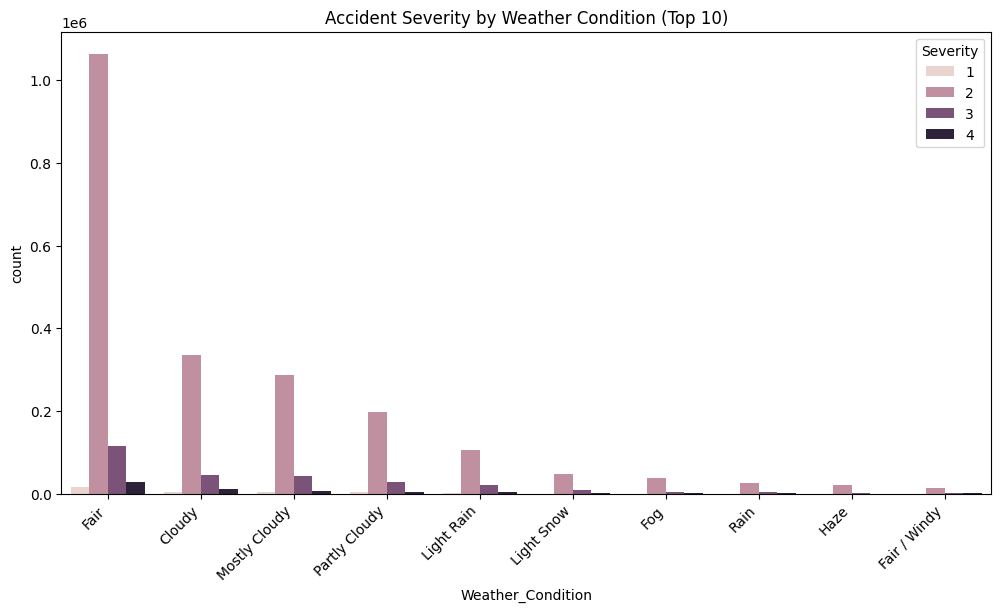

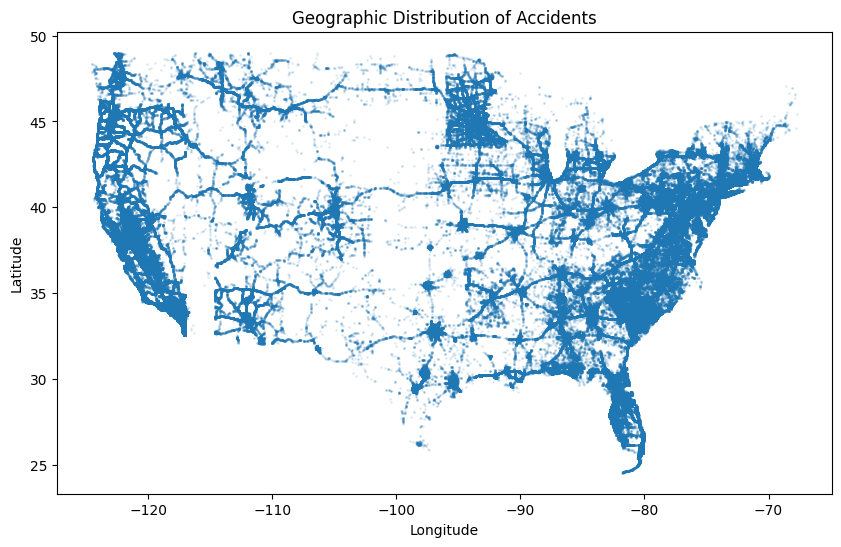

In [54]:

plt.figure(figsize=(8, 6))
sns.countplot(x='Severity', data=accidents_gdf_A.to_pandas())
plt.title('Distribution of Accident Severity')
plt.xlabel('Severity Level')
plt.ylabel('Number of Accidents')
plt.show()


plt.figure(figsize=(12, 6))
sns.countplot(x='Weather_Condition', hue='Severity', data=accidents_gdf_A.to_pandas().dropna(subset=['Weather_Condition']), order=accidents_gdf_A.to_pandas()['Weather_Condition'].value_counts().iloc[:10].index) # Plot only the top 10 weather conditions
plt.title('Accident Severity by Weather Condition (Top 10)')
plt.xticks(rotation=45, ha='right')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(accidents_gdf_A['Start_Lng'].to_pandas(), accidents_gdf_A['Start_Lat'].to_pandas(), s=1, alpha=0.1) # Adjust 's' for marker size and 'alpha' for transparency
plt.title('Geographic Distribution of Accidents')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


                   Severity  Start_Lat  Start_Lng  Distance(mi)  \
Severity           1.000000   0.076854   0.069230      0.030684   
Start_Lat          0.076854   1.000000  -0.096346      0.065653   
Start_Lng          0.069230  -0.096346   1.000000     -0.006200   
Distance(mi)       0.030684   0.065653  -0.006200      1.000000   
Temperature(F)    -0.025278  -0.461010   0.015143     -0.053431   
Wind_Chill(F)     -0.028230  -0.465392   0.000686     -0.057863   
Humidity(%)        0.021308   0.017723   0.180735      0.006485   
Pressure(in)      -0.029577  -0.253841   0.235923     -0.072395   
Visibility(mi)    -0.019265  -0.123477  -0.005753     -0.041568   
Wind_Speed(mph)    0.023848   0.029234   0.087344      0.021355   
Precipitation(in)  0.013214  -0.002585   0.025510      0.002706   

                   Temperature(F)  Wind_Chill(F)  Humidity(%)  Pressure(in)  \
Severity                -0.025278      -0.028230     0.021308     -0.029577   
Start_Lat               -0.461010    

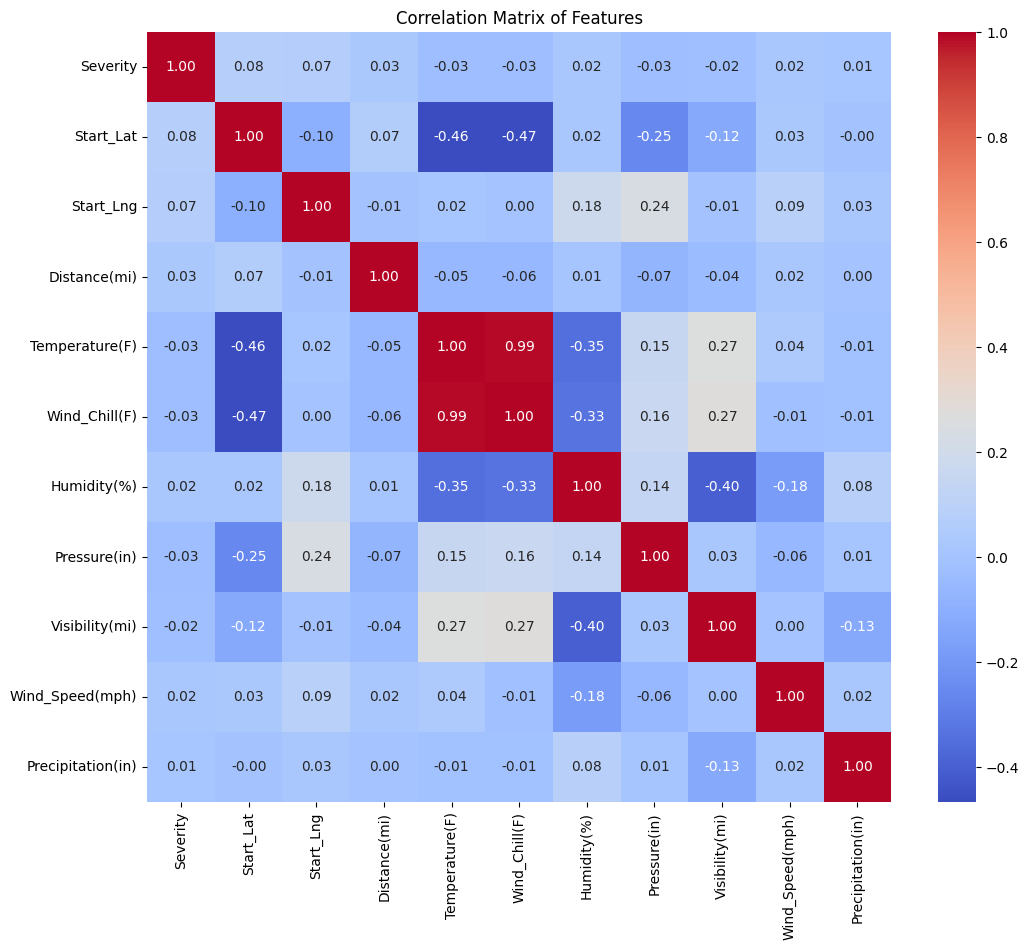

In [51]:
numerical_features = accidents_gdf_A.select_dtypes(include=['number'])
correlation_matrix = numerical_features.corr()

correlation_matrix_pd = correlation_matrix.to_pandas()

print(correlation_matrix_pd)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_pd, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

In [13]:
# Drop half the rows
accidents_gdf_A = accidents_gdf_A.sample(frac=0.5)
print(f"Shape after dropping half the rows: {accidents_gdf_A.shape}")


Shape after dropping half the rows: (3864197, 35)


In [14]:
columns_A = ['Civil_Twilight', 'Nautical_Twilight','Astronomical_Twilight', 'Start_Time']

accidents_gdf_A = accidents_gdf_A.drop(columns=columns_A)
#dropped columns

In [15]:
accidents_gdf_A.shape

(3864197, 31)

In [16]:
missing_percentages = accidents_gdf_A.isnull().mean() * 100
print("Percentage of missing values in each column:")
print(missing_percentages)

Percentage of missing values in each column:
Source                0.000000
Severity              0.000000
Start_Lat             0.000000
Start_Lng             0.000000
Distance(mi)          0.000000
City                  0.003131
County                0.000000
State                 0.000000
Zipcode               0.025025
Temperature(F)        2.118422
Wind_Chill(F)        25.881703
Humidity(%)           2.253172
Pressure(in)          1.820016
Visibility(mi)        2.290489
Wind_Direction        2.265542
Wind_Speed(mph)       7.405238
Precipitation(in)    28.545465
Weather_Condition     2.244554
Amenity               0.000000
Bump                  0.000000
Crossing              0.000000
Give_Way              0.000000
Junction              0.000000
No_Exit               0.000000
Railway               0.000000
Roundabout            0.000000
Station               0.000000
Stop                  0.000000
Traffic_Calming       0.000000
Traffic_Signal        0.000000
Sunrise_Sunset        0.3

In [17]:
accidents_gdf_A.dtypes

,0
Source,object
Severity,int64
Start_Lat,float64
Start_Lng,float64
Distance(mi),float64
City,object
County,object
State,object
Zipcode,object
Temperature(F),float64


dropping the rows from columns with high missing values

In [18]:
cols_low_nan = ['Sunrise_Sunset']

accidents_gdf_A = accidents_gdf_A.dropna(subset=cols_low_nan)


In [19]:
accidents_gdf_A.shape

(3852572, 31)

imputing the nulls in columns with low null value

In [20]:
median_temp = accidents_gdf_A['Temperature(F)'].median()
accidents_gdf_A['Temperature(F)'] = accidents_gdf_A['Temperature(F)'].fillna(median_temp)

median_humidity = accidents_gdf_A['Humidity(%)'].median()
accidents_gdf_A['Humidity(%)'] = accidents_gdf_A['Humidity(%)'].fillna(median_humidity)

median_pressure = accidents_gdf_A['Pressure(in)'].median()
accidents_gdf_A['Pressure(in)'] = accidents_gdf_A['Pressure(in)'].fillna(median_pressure)

median_visibility = accidents_gdf_A['Visibility(mi)'].median()
accidents_gdf_A['Visibility(mi)'] = accidents_gdf_A['Visibility(mi)'].fillna(median_visibility)

median_wind_speed = accidents_gdf_A['Wind_Speed(mph)'].median()
accidents_gdf_A['Wind_Speed(mph)'] = accidents_gdf_A['Wind_Speed(mph)'].fillna(median_wind_speed)

mode_wind_direction = accidents_gdf_A['Wind_Direction'].mode()[0]
accidents_gdf_A['Wind_Direction'] = accidents_gdf_A['Wind_Direction'].fillna(mode_wind_direction)

mode_weather = accidents_gdf_A['Weather_Condition'].mode()[0]
accidents_gdf_A['Weather_Condition'] = accidents_gdf_A['Weather_Condition'].fillna(mode_weather)



null_counts = accidents_gdf_A.isnull().sum()
print("\nRemaining null values per column:")

print(null_counts[null_counts > 0])

print(f"\nFinal DataFrame shape: {accidents_gdf_A.shape}")


Remaining null values per column:
Zipcode                  947
Wind_Chill(F)         998522
Precipitation(in)    1101534
dtype: int64

Final DataFrame shape: (3852572, 31)


In [21]:
accidents_gdf_A = accidents_gdf_A.dropna(subset=['Zipcode'])
accidents_gdf_A = accidents_gdf_A.dropna(subset=['Wind_Chill(F)'])
accidents_gdf_A = accidents_gdf_A.dropna(subset=['Precipitation(in)'])

In [22]:
X_A = accidents_gdf_A.drop(columns=['Severity'])
y_A = accidents_gdf_A['Severity']

X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A, test_size=0.3, random_state=42)

print(f"X_train_A shape: {X_train_A.shape}")
print(f"X_test_A shape: {X_test_A.shape}")
print(f"y_train_A shape: {y_train_A.shape}")
print(f"y_test_A shape: {y_test_A.shape}")

X_train_A shape: (1838345, 30)
X_test_A shape: (787862, 30)
y_train_A shape: (1838345,)
y_test_A shape: (787862,)


In [23]:
accidents_gdf_A.dtypes

,0
Source,object
Severity,int64
Start_Lat,float64
Start_Lng,float64
Distance(mi),float64
City,object
County,object
State,object
Zipcode,object
Temperature(F),float64


In [24]:
ohe_cols = ['Sunrise_Sunset','State', 'Source']

In [25]:
freq_cols = ['Weather_Condition', 'Wind_Direction', 'City', 'County', 'Zipcode', 'Precipitation(in)', 'Wind_Chill(F)']

In [26]:
X_train_A = cudf.get_dummies(X_train_A, columns=ohe_cols, drop_first=True)
X_test_A = cudf.get_dummies(X_test_A, columns=ohe_cols, drop_first=True)

In [27]:
for col in freq_cols:
    frequency_map = X_train_A[col].value_counts(normalize=True)
    X_train_A[col + '_freq'] = X_train_A[col].map(frequency_map)
    X_test_A[col + '_freq'] = X_test_A[col].map(frequency_map).fillna(1e-6)

X_train_A = X_train_A.drop(columns=freq_cols)
X_test_A = X_test_A.drop(columns=freq_cols)

print("--- Frequency Encoding completed ---")
print(f"New X_train_A shape: {X_train_A.shape}")
print(f"New X_test_A shape: {X_test_A.shape}")

--- Frequency Encoding completed ---
New X_train_A shape: (1838345, 78)
New X_test_A shape: (787862, 78)


In [28]:

bool_cols = [col for col in X_train_A.columns if X_train_A[col].dtype == 'bool']

# Convert boolean columns to 0 and 1 in both training and testing sets
for col in bool_cols:
    X_train_A[col] = X_train_A[col].astype(int)
    X_test_A[col] = X_test_A[col].astype(int)


In [29]:
X_train_A.shape

(1838345, 78)

In [30]:
import xgboost as xgb
import time
from sklearn.metrics import classification_report, accuracy_score


In [31]:
scaler = StandardScaler()
X_train_A_scaled = scaler.fit_transform(X_train_A)
X_test_A_scaled = scaler.transform(X_test_A)


In [33]:
X_train_A_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,0.155274,-1.607618,-0.335013,-0.590158,-0.172124,0.501246,0.376024,-0.432247,9.147745,-0.022834,...,-0.022181,-0.659894,-0.11501,1.047079,-0.421937,-0.506091,-0.589259,-0.719427,0.293353,0.416906
1,-1.337332,0.688092,-0.274700,-0.850300,-0.303698,0.664549,0.376024,-1.343845,-0.109317,-0.022834,...,-0.022181,-0.659894,-0.11501,1.047079,2.108288,-0.366268,-0.267066,-0.716927,0.293353,-0.628920
2,0.709166,1.062382,-0.305672,-0.954356,-0.172124,-0.097533,0.376024,-1.343845,-0.109317,-0.022834,...,-0.022181,-0.659894,-0.11501,-0.947990,2.108288,-0.574611,-0.523529,-0.719427,0.293353,-0.663026
3,1.118618,0.346909,-0.361094,0.918660,-0.654563,-0.224546,0.376024,1.573267,-0.109317,-0.022834,...,-0.022181,-0.659894,-0.11501,-0.624897,-0.677603,-0.575088,-0.713157,-0.704427,0.293353,1.045631
4,-1.092657,0.573336,-0.361094,0.970688,0.617321,0.437739,0.376024,-0.067609,-0.109317,-0.022834,...,-0.022181,1.515395,-0.11501,-0.729242,0.121380,-0.427475,-0.652349,-0.719427,0.293353,0.379347


In [34]:

print(accidents_gdf['Severity'].value_counts())

Severity
2    6156981
3    1299337
4     204710
1      67366
Name: count, dtype: int64


In [35]:
y_train_A = cudf.Series(y_train_A).astype('int32') - 1
y_test_A = cudf.Series(y_test_A).astype('int32') - 1
print(f"Target values (Train) after shifting: {cudf.Series(y_train_A).unique().to_pandas().tolist()}")

Target values (Train) after shifting: [1, 2, 0, 3]


In [37]:
start_time = time.time()
rf_model_gpu = cuml.ensemble.RandomForestClassifier(n_estimators=300, max_depth=16, n_bins=128, random_state=42, n_streams=1)
rf_model_gpu.fit(X_train_A_scaled, y_train_A)
rf_train_time_gpu = time.time() - start_time
print(f"GPU Random Forest trained in {rf_train_time_gpu:.2f} seconds.")

start_time = time.time()
y_pred_rf_gpu = rf_model_gpu.predict(X_test_A_scaled)
rf_predict_time_gpu = time.time() - start_time

y_test_int = cudf.Series(y_test_A).astype('int32')
y_pred_int = cudf.Series(y_pred_rf_gpu).astype('int32')

rf_accuracy_gpu = cuml.metrics.accuracy_score(y_test_int, y_pred_int)

print(f"GPU RF Accuracy: {rf_accuracy_gpu:.4f}")
print(f"GPU RF Predict Time: {rf_predict_time_gpu:.2f}s")

GPU Random Forest trained in 54.38 seconds.
GPU RF Accuracy: 0.8760
GPU RF Predict Time: 0.39s


In [38]:

start_time = time.time()

lr_model_gpu = cuml.linear_model.LogisticRegression(solver='qn', max_iter=1000)
lr_model_gpu.fit(X_train_A_scaled, y_train_A)
lr_train_time_gpu = time.time() - start_time
print(f"GPU Logistic Regression trained in {lr_train_time_gpu:.2f} seconds.")


start_time = time.time()
y_pred_lr_gpu = lr_model_gpu.predict(X_test_A_scaled)
lr_predict_time_gpu = time.time() - start_time


y_test_int = cudf.Series(y_test_A).astype('int32')
y_pred_int = cudf.Series(y_pred_lr_gpu).astype('int32')

accuracy_lr_gpu = cuml.metrics.accuracy_score(y_test_int, y_pred_int)

print(f"GPU LR Predict Time: {lr_predict_time_gpu:.2f}s")
print(f"GPU LR Accuracy: {accuracy_lr_gpu:.4f}")


GPU Logistic Regression trained in 1.27 seconds.
GPU LR Predict Time: 0.02s
GPU LR Accuracy: 0.8696


In [39]:
num_classes = cudf.Series(y_train_A).nunique()
print(f"Number of unique classes detected: {num_classes}")


print("Training XGBoost (GPU)...")
start_time = time.time()

xgb_model_gpu = xgb.XGBClassifier( objective='multi:softmax', num_class=num_classes,tree_method='gpu_hist',n_estimators=100, max_depth=10, use_label_encoder=False,
 eval_metric='mlogloss'
,random_state=42
)

xgb_model_gpu.fit(X_train_A_scaled, y_train_A)
xgb_train_time_gpu = time.time() - start_time
print(f"GPU XGBoost trained in {xgb_train_time_gpu:.2f} seconds.")

start_time = time.time()

y_pred_xgb_gpu = xgb_model_gpu.predict(X_test_A_scaled)
xgb_predict_time_gpu = time.time() - start_time



y_test_int = cudf.Series(y_test_A).astype('int32')

y_pred_int = cudf.Series(y_pred_xgb_gpu).astype('int32')

accuracy_xgb_gpu = cuml.metrics.accuracy_score(y_test_int, y_pred_int)

print(f"GPU XGBoost Predict Time: {xgb_predict_time_gpu:.2f}s")
print(f"GPU XGBoost Accuracy: {accuracy_xgb_gpu:.4f}")


Number of unique classes detected: 4
Training XGBoost (GPU)...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:17:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:17:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GPU XGBoost trained in 7.87 seconds.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:17:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


GPU XGBoost Predict Time: 0.23s
GPU XGBoost Accuracy: 0.9078


In [40]:
# Take a random sample of 200 rows
sampled_df = accidents_gdf_A.sample(n=200, random_state=42) # Setting random_state for reproducibility

# Save the sampled DataFrame to a new CSV file
sampled_df.to_csv('test.csv', index=False)

In [41]:
# Save X_test and y_test as CSV files
X_test_A_scaled.to_csv('X_test.csv', index=False)
y_test_A.to_pandas().to_csv('y_test.csv', index=False) # Convert y_test to pandas Series before calling to_csv

In [42]:
import joblib

# Save the trained model
joblib.dump(xgb_model_gpu, 'xgb_model.joblib')

# Save the scaler
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [43]:
import pandas as pd
import cudf
import joblib
from cuml.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

def make_prediction(input_data):
    # Load the saved model and scaler
    loaded_model = joblib.load('xgb_model.joblib')
    loaded_scaler = joblib.load('scaler.joblib')

    # Convert input data to a DataFrame (if it's not already)
    if not isinstance(input_data, pd.DataFrame):
        input_data = pd.DataFrame(input_data)

    # Convert pandas DataFrame to cuDF DataFrame
    input_data_cudf = cudf.DataFrame.from_pandas(input_data)

    # Scale the input data using the loaded scaler
    input_data_scaled = loaded_scaler.transform(input_data_cudf)

    # Make predictions using the loaded model
    predictions = loaded_model.predict(input_data_scaled)

    # You might want to load y_test here if you need to calculate accuracy
    y_test = pd.read_csv('y_test.csv')
    accuracy = accuracy_score(y_test, predictions.to_pandas())
    print(f"Model Accuracy: {accuracy:.4f}")

    print("Predictions:", predictions.to_pandas()) # Convert to pandas for printing
    return predictions.to_pandas() #Return as pandas Series


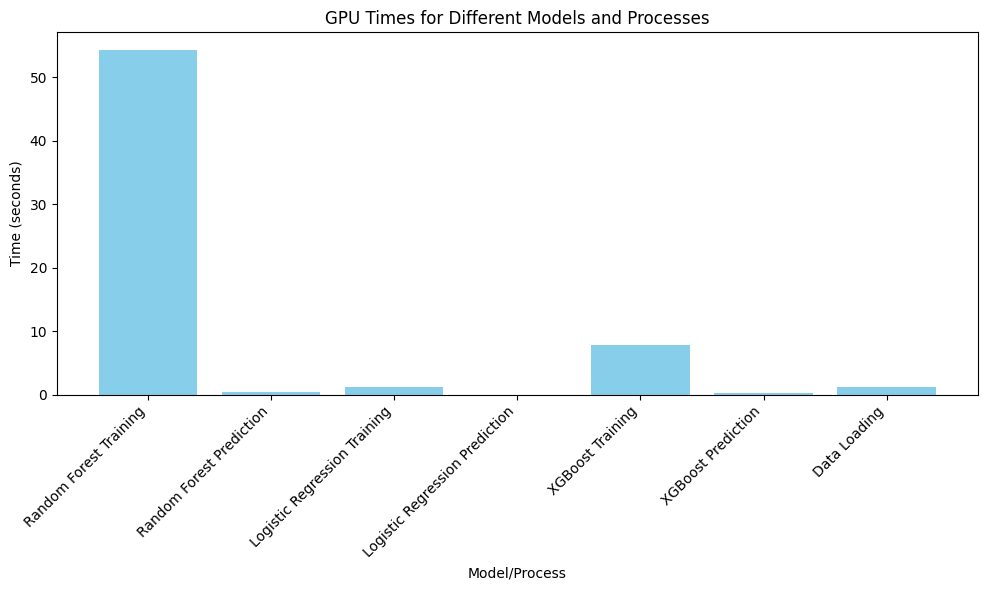

In [44]:

import matplotlib.pyplot as plt

gpu_times = {
    'Random Forest Training': rf_train_time_gpu,
    'Random Forest Prediction': rf_predict_time_gpu,
    'Logistic Regression Training': lr_train_time_gpu,
    'Logistic Regression Prediction': lr_predict_time_gpu,
    'XGBoost Training': xgb_train_time_gpu,
    'XGBoost Prediction': xgb_predict_time_gpu,
    'Data Loading': load_time
}

models = list(gpu_times.keys())
times = list(gpu_times.values())

plt.figure(figsize=(10, 6))
plt.bar(models, times, color='skyblue')
plt.xlabel("Model/Process")
plt.ylabel("Time (seconds)")
plt.title("GPU Times for Different Models and Processes")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()
